# Laboratorio #8
## Defensa contra el ataque de extracción
- Marco Ramírez
- Estuardo Hernández

## Preparación de la data para los ataques

In [45]:
# Importamos las librerías a utilizar
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from art.estimators.classification import KerasClassifier # No soporta TF 2
tf.compat.v1.disable_eager_execution()
import pandas as pd
import os
from PIL import Image
from keras.utils import image_dataset_from_directory
from art.attacks.extraction import CopycatCNN
from keras import models, layers
import tensorflow_datasets as tfds
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [46]:
# Utilizamos las 939 imágenes que separamos para el ataque y creamos un dataframe
dir = "./random_imgs/"
imgs_location = './selected/selected'
data = []
for family in os.scandir(dir):
    if family.is_dir:
        for malware in os.scandir(family):
            width, height = Image.open(malware.path).size
            data.append({ 
                "name": malware.name, 
                "path": malware.path,
                "family": family.name,
                "width": width,
                "height": height,
            })
    

df = pd.DataFrame(data, columns=["name", "path", "family", "width", "height"])
df

,name,path,family,width,height
0,000e30a0819ac7ed931d629ce2ef8948.png,./random_imgs/Adialer.C\000e30a0819ac7ed931d62...,Adialer.C,512,409
1,002f06eff1d222560939be72583d6ae9.png,./random_imgs/Adialer.C\002f06eff1d222560939be...,Adialer.C,512,410
2,0046a83d932a3d431eb21a99b46d6af7.png,./random_imgs/Adialer.C\0046a83d932a3d431eb21a...,Adialer.C,512,409
3,01aa7da4d2709a0ceb69771fc837730c.png,./random_imgs/Adialer.C\01aa7da4d2709a0ceb6977...,Adialer.C,512,409
4,01fac2472eab8532d8f5951ff48637d4.png,./random_imgs/Adialer.C\01fac2472eab8532d8f595...,Adialer.C,512,410
...,...,...,...,...,...
934,07df93176f9eb61f1cb7a885d8829fbb.png,./random_imgs/Yuner.A\07df93176f9eb61f1cb7a885...,Yuner.A,768,683
935,08004d4675258aa177d07235eb0375ed.png,./random_imgs/Yuner.A\08004d4675258aa177d07235...,Yuner.A,768,683
936,0823d0fa9e21cee43174ecd9931846d4.png,./random_imgs/Yuner.A\0823d0fa9e21cee43174ecd9...,Yuner.A,768,683
937,0860ed8a40ea6a2acd816426da6ed1a9.png,./random_imgs/Yuner.A\0860ed8a40ea6a2acd816426...,Yuner.A,768,683


In [47]:
# Agrupamos por familia
def get_stratified_sample(df, amount, seed=12345):
    return df.groupby('family', as_index=False, group_keys=False) \
                .apply(lambda s: s.sample(min(amount, len(s)), random_state=seed))
df2 = get_stratified_sample(df, 100)

In [ ]:
# Extraemos el path de cada imagen a una carpeta
for _, row in df2.iterrows():
    os.makedirs(os.path.join(imgs_location, row['family']), exist_ok=True)
    os.symlink(os.path.abspath(row['path']), os.path.join(imgs_location, row['family'], row['name']))

In [48]:
# Dividir en entrenamiento y prueba
test_data = image_dataset_from_directory(
    imgs_location,
    image_size=(80, 80),
    shuffle=True,
    validation_split=0.2,
    subset='validation',
    seed=191919,
)


training_data = image_dataset_from_directory(
    imgs_location,
    image_size=(80, 80),
    shuffle=True,
    validation_split=0.2,
    subset='training',
    seed=191919,
)

Found 672 files belonging to 25 classes.
Using 134 files for validation.
Found 672 files belonging to 25 classes.
Using 538 files for training.


## Ataque de extracción

In [49]:
# Cargamos el modelo
vulnerable_model = tf.keras.models.load_model("malware-class.h5")

In [50]:
# Utilizamos el KerasClassifier
clasificador = KerasClassifier(
    model=vulnerable_model
)

In [51]:
# Crear la red neuronal que robará el modelo original
copycat_cnn = CopycatCNN(
    batch_size_fit=80,
    batch_size_query=80,
    nb_epochs=20,
    nb_stolen=20000,
    classifier=clasificador
    )

In [52]:
# Definimos un nuevo modelo
blank_model = models.Sequential([
  layers.Rescaling(1./255, input_shape=(80, 80, 3)),     # normalizacion
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(len(test_data.class_names), activation='softmax')
])

# Compilamos el modelo
blank_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [53]:
# Definimos el modelo robado
model_stolen = KerasClassifier(
    model=blank_model
)

In [54]:
# Agregamos etiquetas a cada imagen
training_labels = []
training_images = []
for image, label in tfds.as_numpy(training_data):
    training_labels.extend(label)
    training_images.extend(image)

In [55]:
# Extraemos el modelo robado entrenando el modelo referenciado
stolen_classifier = copycat_cnn.extract(
    x=np.array(training_images), 
    y=np.array(training_labels), 
    thieved_classifier=model_stolen
    )

c:\Users\xavih\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Train on 538 samples
Epoch 1/20
538/538 [==============================] - 2s 4ms/sample - loss: 1.2550 - accuracy: 0.7751
Epoch 2/20
538/538 [==============================] - 2s 3ms/sample - loss: 0.4949 - accuracy: 0.9108
Epoch 3/20
538/538 [==============================] - 2s 3ms/sample - loss: 0.3619 - accuracy: 0.9108
Epoch 4/20
538/538 [==============================] - 2s 3ms/sample - loss: 0.2629 - accuracy: 0.9182
Epoch 5/20
538/538 [==============================] - 1s 3ms/sample - loss: 0.2107 - accuracy: 0.9294
Epoch 6/20
538/538 [==============================] - 2s 3ms/sample - loss: 0.1709 - accuracy: 0.9610
Epoch 7/20
538/538 [==============================] - 1s 3ms/sample - loss: 0.1543 - accuracy: 0.9591
Epoch 8/20
538/538 [==============================] - 2s 3ms/sample - loss: 0.1240 - accuracy: 0.9665
Epoch 9/20
538/538 [==============================] - 2s 3ms/sample - loss: 0.0966 - accuracy: 0.9758
Epoch 10/20
538/538 [==============================] - 1s 3ms

In [56]:
# Para comparar el modelo original con el robado, predecimos las labels utilizando ambos modelos con las imagenes de test
# Primero el modelo original
og_probabilities = []
og_true_labels = []

test_images, test_labels = zip(*tfds.as_numpy(test_data))
for img_batch, label_batch in zip(test_images, test_labels):
    probability_batch = clasificador.predict(img_batch)
    og_probabilities.extend(probability_batch)
    og_true_labels.extend(label_batch)

og_probabilities = np.array(og_probabilities)
og_true_labels = np.array(og_true_labels)

og_predicted_labels = np.argmax(og_probabilities, axis=-1)

In [57]:
# Ahora el modelo robado
stolen_probabilities = []
stolen_true_labels = []

for img_batch, label_batch in zip(test_images, test_labels):
    probability_batch = stolen_classifier.predict(img_batch)
    stolen_probabilities.extend(probability_batch)
    stolen_true_labels.extend(label_batch)

stolen_probabilities = np.array(stolen_probabilities)
stolen_true_labels = np.array(stolen_true_labels)

stolen_predicted_labels = np.argmax(stolen_probabilities, axis=-1)

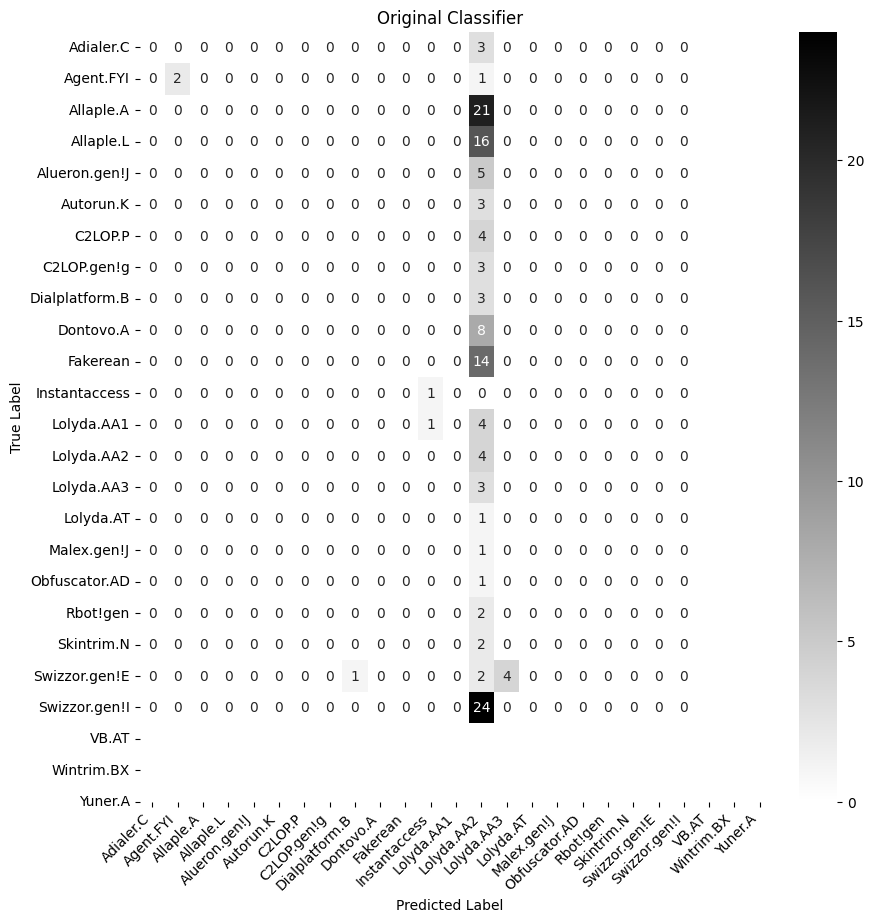

In [58]:
# Comparamos utilizando una matriz de confusion del modelo original
cm = confusion_matrix(og_true_labels, og_predicted_labels)
plt.figure(figsize=(10, 10))
heatmap = sns.heatmap(cm, annot=True, fmt='d', cmap='binary', cbar=True, xticklabels=test_data.class_names, yticklabels=test_data.class_names)
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Original Classifier')
plt.show()

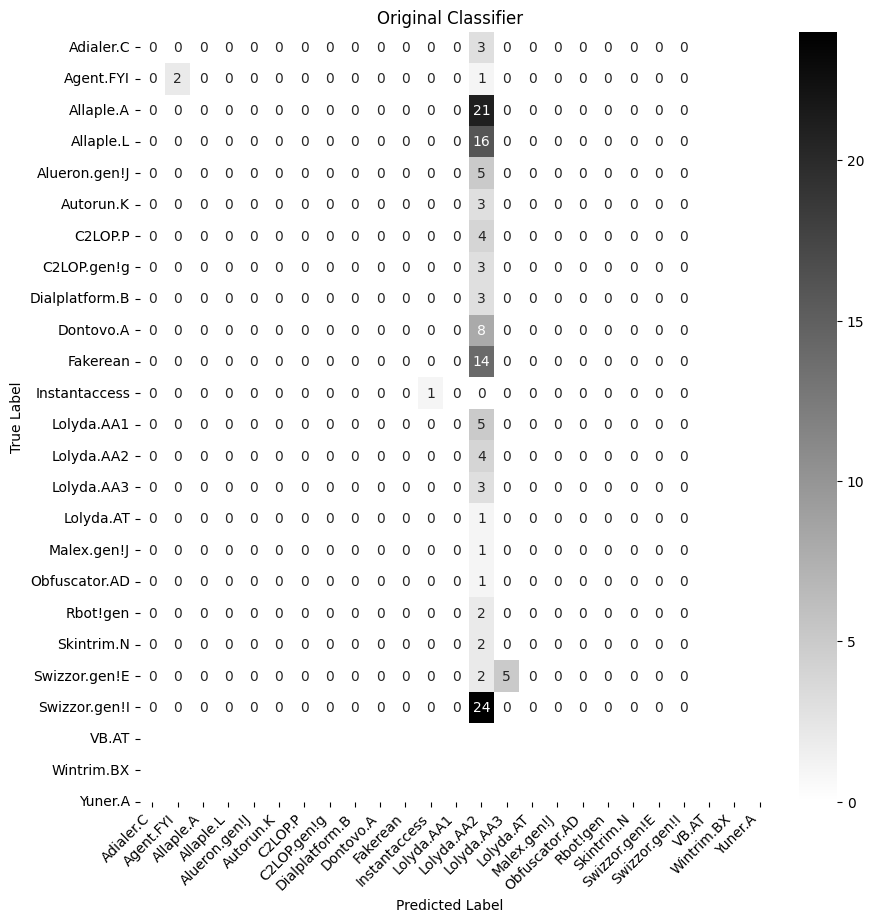

In [59]:
# Ahora la matriz de confusion del modelo robado
cm = confusion_matrix(stolen_true_labels, stolen_predicted_labels)
plt.figure(figsize=(10, 10))
heatmap = sns.heatmap(cm, annot=True, fmt='d', cmap='binary', cbar=True, xticklabels=test_data.class_names, yticklabels=test_data.class_names)
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Original Classifier')
plt.show()

Vemos que ambos clasifican de manera muy similar lo que indica que el ataque fue realizado con éxito porque se extrajo un modelo existente que funciona casi igual y con una precisión no tan lejana a la del original porque son pocos casos que no clasifica de la misma manera que el original.

## Ataque de envenenamiento

In [60]:
test_data = image_dataset_from_directory(
    imgs_location,
    image_size=(80, 80),
    shuffle=True,
    seed=191919,
)

test_labels = []
test_images = []
for image, label in tfds.as_numpy(test_data):
    test_labels.extend(label)
    test_images.extend(image)

test_images = np.array(test_images)
test_labels = np.array(test_labels)

Found 672 files belonging to 25 classes.


In [61]:
# Importamos las librerias a utilizar
from art.attacks.evasion import FastGradientMethod

# Ataque FGSM al clasificador con perturbación de 0.9
attack_fgsm = FastGradientMethod(
    estimator=clasificador, 
    eps=0.9,
)

In [62]:
# Generamos ejemplos adversarios
test_images_mal = attack_fgsm.generate(x=np.array(test_images))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

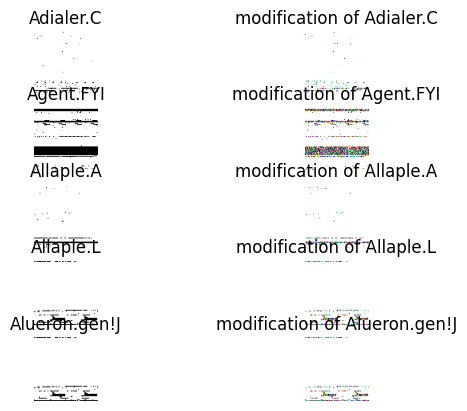

In [63]:
# Comparar las imagenes originales con las alteradas
for i in range(5):
    original = test_images[i]
    modified = test_images_mal[i]
    label = test_data.class_names[i]

    plt.subplot(5, 2, i*2+1)
    plt.imshow(original)
    plt.title(label)
    plt.axis('off')

    plt.subplot(5, 2, i*2+2)
    plt.imshow(modified)
    plt.title(f"modification of {label}")
    plt.axis('off')
plt.show()

In [64]:
# Predicción de las etiquetas de las imagenes originales
probabilities = clasificador.predict(test_images)
probabilities = np.array(probabilities)
predicted_labels = np.argmax(probabilities, axis=-1)

In [65]:
# Predicción de las etiquetas de las imagenes alteradas
alt_probabilities = clasificador.predict(test_images_mal)
alt_probabilities = np.array(alt_probabilities)
alt_predicted_labels = np.argmax(alt_probabilities, axis=-1)

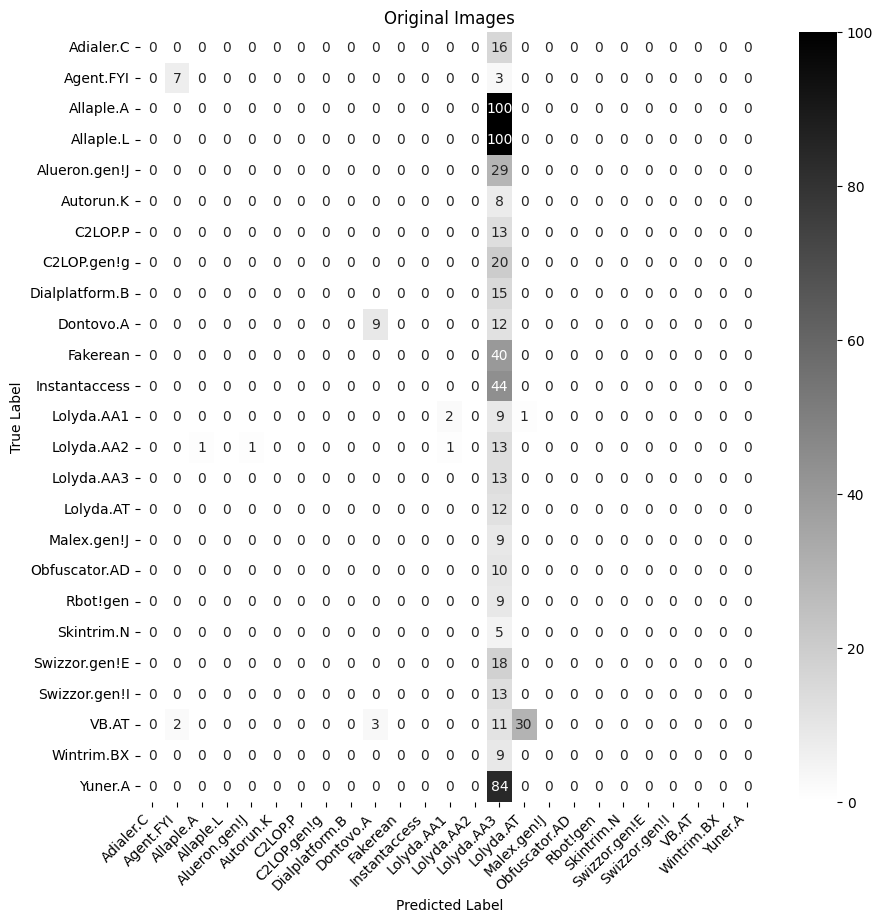

In [66]:
# Matriz de confusion de prediccion de las imagenes originales
cm = confusion_matrix(test_labels, predicted_labels)
plt.figure(figsize=(10, 10))
heatmap = sns.heatmap(cm, annot=True, fmt='d', cmap='binary', cbar=True, xticklabels=test_data.class_names, yticklabels=test_data.class_names)
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Original Images')
plt.show()

In [67]:
from sklearn.metrics import classification_report

# Calcular las métricas a partir de la matriz de confusión
classification_metrics1 = classification_report(test_labels, predicted_labels, target_names=test_data.class_names)

# Mostrar las métricas
print(classification_metrics1)

                precision    recall  f1-score   support

     Adialer.C       0.00      0.00      0.00        16
     Agent.FYI       0.78      0.70      0.74        10
     Allaple.A       0.00      0.00      0.00       100
     Allaple.L       0.00      0.00      0.00       100
 Alueron.gen!J       0.00      0.00      0.00        29
     Autorun.K       0.00      0.00      0.00         8
       C2LOP.P       0.00      0.00      0.00        13
   C2LOP.gen!g       0.00      0.00      0.00        20
Dialplatform.B       0.00      0.00      0.00        15
     Dontovo.A       0.75      0.43      0.55        21
      Fakerean       0.00      0.00      0.00        40
 Instantaccess       0.00      0.00      0.00        44
    Lolyda.AA1       0.67      0.17      0.27        12
    Lolyda.AA2       0.00      0.00      0.00        16
    Lolyda.AA3       0.02      1.00      0.04        13
     Lolyda.AT       0.00      0.00      0.00        12
   Malex.gen!J       0.00      0.00      0.00  

c:\Users\xavih\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\xavih\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\xavih\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

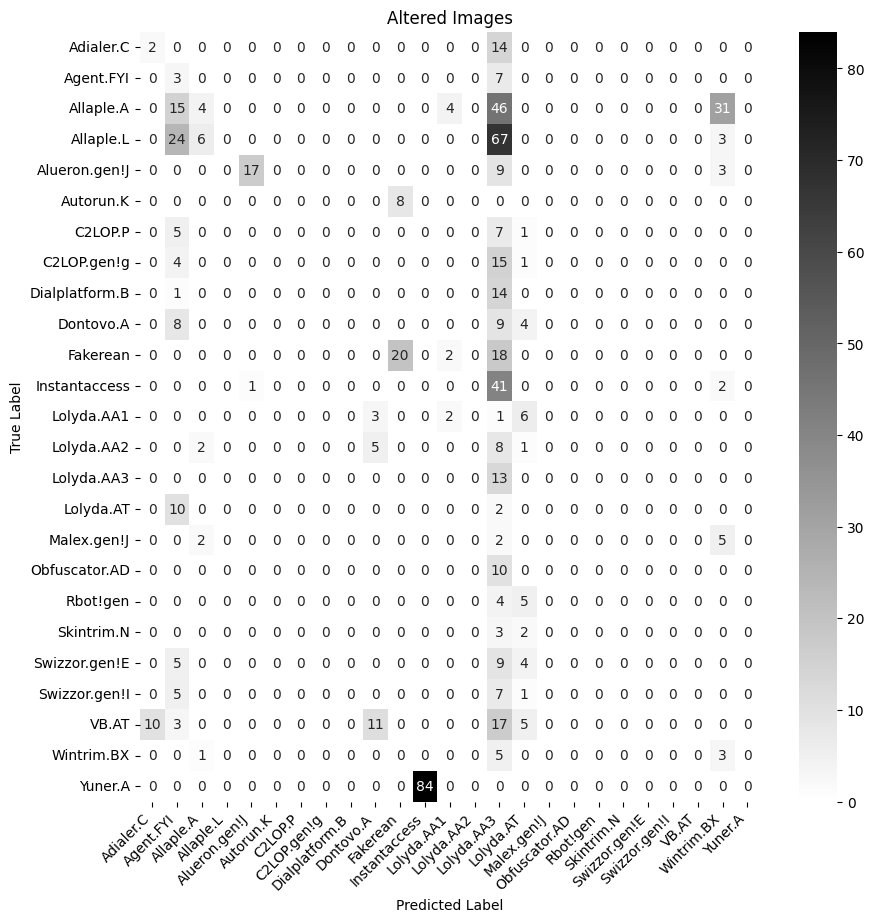

In [68]:
# Matriz de confusion de prediccion de las imagenes alteradas
cm = confusion_matrix(test_labels, alt_predicted_labels)
plt.figure(figsize=(10, 10))
heatmap = sns.heatmap(cm, annot=True, fmt='d', cmap='binary', cbar=True, xticklabels=test_data.class_names, yticklabels=test_data.class_names)
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Altered Images')
plt.show()

In [69]:
from sklearn.metrics import classification_report

# Calcular las métricas a partir de la matriz de confusión
classification_metrics2 = classification_report(test_labels, alt_predicted_labels, target_names=test_data.class_names)

# Mostrar las métricas
print(classification_metrics2)

                precision    recall  f1-score   support

     Adialer.C       0.17      0.12      0.14        16
     Agent.FYI       0.04      0.30      0.06        10
     Allaple.A       0.27      0.04      0.07       100
     Allaple.L       0.00      0.00      0.00       100
 Alueron.gen!J       0.94      0.59      0.72        29
     Autorun.K       0.00      0.00      0.00         8
       C2LOP.P       0.00      0.00      0.00        13
   C2LOP.gen!g       0.00      0.00      0.00        20
Dialplatform.B       0.00      0.00      0.00        15
     Dontovo.A       0.00      0.00      0.00        21
      Fakerean       0.71      0.50      0.59        40
 Instantaccess       0.00      0.00      0.00        44
    Lolyda.AA1       0.25      0.17      0.20        12
    Lolyda.AA2       0.00      0.00      0.00        16
    Lolyda.AA3       0.04      1.00      0.08        13
     Lolyda.AT       0.00      0.00      0.00        12
   Malex.gen!J       0.00      0.00      0.00  

c:\Users\xavih\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\xavih\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\xavih\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

El ataque fue realizado con éxito porque se logra obsevar que las imágenes fueron alteradas o modificadas correctamente, causando que el modelo se confnda y que clasifique de forma diferente.